In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    gpu_info = torch.cuda.get_device_properties(0)
    print(f"GPU: {gpu_info.name}")
    print(f"GPU memory: {gpu_info.total_memory / 1024**2:.2f} MB")

GPU: NVIDIA GeForce RTX 3090
GPU memory: 24252.69 MB


In [3]:
class GreenFun(nn.Module):
    def __init__(self, N):     
        super(GreenFun, self).__init__()
        self.N = N
        self.lambda_layer = nn.Sequential(nn.Linear(1, N // 4), nn.ReLU(), nn.Linear(N // 4, N // 4), nn.ReLU(), nn.Linear(N // 4, N // 4), nn.ReLU(), nn.Linear(N // 4, N // 4), nn.ReLU(), nn.Linear(N // 4, N // 4))
        self.G_layer1 = nn.Sequential(nn.Linear(N, N // 4, bias = False))
        self.G_layer2 = nn.Sequential(nn.Linear(N // 4, N, bias = False))

    def forward(self, lambda_values,  f):   
        return self.G_layer2(self.lambda_layer(lambda_values) * self.G_layer1(f))

In [4]:
class MLP(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output, n_layers):
        super(MLP, self).__init__()
        self.act = nn.ReLU()
        self.layin = torch.nn.Linear(n_input, n_hidden)
        self.hidden_layers = torch.nn.ModuleList([torch.nn.Linear(n_hidden, n_hidden) for _ in range(n_layers)])
        self.layout = torch.nn.Linear(n_hidden, n_output)
    def forward(self, g):
       g = self.layin(g)
       g = self.act(g)
       for layer in self.hidden_layers:
           g = layer(g)
           g = self.act(g)
       h = self.layout(g)
       return h
    
class DeepONet(torch.nn.Module):
    def __init__(self, N):
        super(DeepONet, self).__init__()
        self.for_tau = MLP(1, N, N, 2)
        self.for_g_1 = torch.nn.Linear(N, N, bias = False)
        self.for_g_2 = torch.nn.Linear(N, N, bias = False)
    def forward(self, tau, g):      #  tau: scalar, g: (batch_size, n_g)
       tau = tau + torch.zeros_like(g[:, 1].view(-1, 1))
       tau = self.for_tau(tau)
       g = self.for_g_1(g)
       h = self.for_g_2(tau * g)
       return h

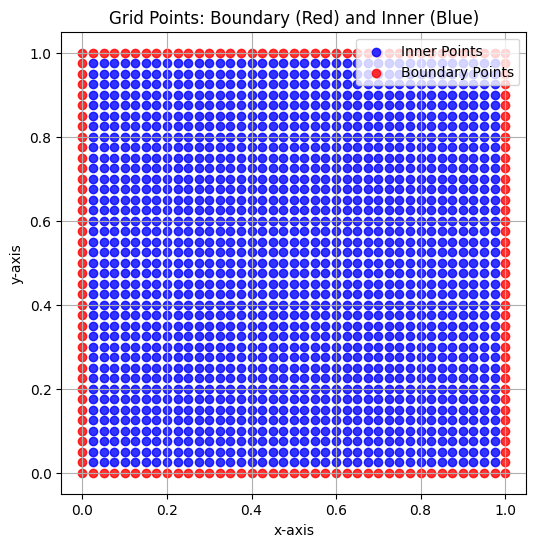

In [5]:
N = 41
x_pt = torch.zeros(N * N, 2).to(device)
for i in range(N):
    for j in range(N):
        x_pt[i * N + j, 0] = 1 * j / (N - 1) 
        x_pt[i * N + j, 1] = 1 * i / (N - 1)  

boundary_mask = (
    (x_pt[:, 0] == 0) | (x_pt[:, 0] == 1) |  
    (x_pt[:, 1] == 0) | (x_pt[:, 1] == 1)   
)
x_bd_pt = x_pt[boundary_mask] 
x_int_pt = x_pt[~boundary_mask]  

plt.figure(figsize=(6, 6))
plt.scatter(x_int_pt[:, 0].cpu(), x_int_pt[:, 1].cpu(), c='blue', label='Inner Points', alpha=0.8)
plt.scatter(x_bd_pt[:, 0].cpu(), x_bd_pt[:, 1].cpu(), c='red', label='Boundary Points', alpha=0.8)
plt.legend()
plt.title("Grid Points: Boundary (Red) and Inner (Blue)")
plt.xlabel("x-axis")
plt.ylabel("y-axis")
plt.grid(True)
plt.show()

In [6]:
n = N - 1
h = 1 / n 
m = n - 1
m2 = m * m
netF = GreenFun(2 * m2).to(device)
netF.load_state_dict(torch.load("./GreenNet3/net.pth", map_location = device, weights_only=True))

<All keys matched successfully>

In [7]:
Ng = 128
netg = DeepONet(8 * Ng).to(device)
netg.load_state_dict(torch.load("./BINet3/net.pth", map_location = device, weights_only=True))

<All keys matched successfully>

In [8]:
def generate_square_points(n):
    # Boundary points per side without including corners
    boundary_spacing = np.linspace(1 / (2 * n), 1 - 1 / (2 * n), n)
    
    # Bottom boundary (x varies, y is 0)
    bottom_boundary = np.column_stack((boundary_spacing, np.zeros(n)))
    # Right boundary (x is 1, y varies)
    right_boundary = np.column_stack((np.ones(n), boundary_spacing))
    # Top boundary (x varies, y is 1)
    top_boundary = np.column_stack((boundary_spacing[::-1], np.ones(n)))
    # Left boundary (x is 0, y varies)
    left_boundary = np.column_stack((np.zeros(n), boundary_spacing[::-1]))
    
    # Combine boundary points in sequence
    boundary_points = np.vstack([bottom_boundary, right_boundary, top_boundary, left_boundary])

    t_boundary = np.zeros((len(boundary_points), 1)) 
    for i in range(len(boundary_points)):
        if(boundary_points[i,1] == 0):
            t_boundary[i] = boundary_points[i,0]
        elif(boundary_points[i,0] == 1):
            t_boundary[i] = 1 + boundary_points[i,1]
        elif(boundary_points[i,1] == 1):
            t_boundary[i] = 3 - boundary_points[i,0]
        else:
            t_boundary[i] = 4 - boundary_points[i,1]
    
    return 1 / n, t_boundary, boundary_points

h_g, s_for_integral, x_bd_g = generate_square_points(Ng)
s_for_intergal_pt = torch.from_numpy(s_for_integral).clone().float().to(device).view(-1, 1)
x_bd_g_pt = torch.from_numpy(x_bd_g).clone().float().to(device)

In [9]:
lambda_values = [0.06, 0.07, 0.08]
lambda_values

[0.06, 0.07, 0.08]

In [10]:
from scipy.special import keip, kerp, kei, ker

def kernel_1_1_int(lambda_, x, s):  # lambda * G_i_j
    x1, x2 = x[0], x[1]
    if s < 1:
        x1_s, x2_s, x1_prime_s, x2_prime_s = s, 0, 1, 0
    elif s < 2:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 1, s - 1, 0, 1
    elif s < 3:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 3 - s, 1, - 1, 0
    else:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 0, 4 - s, 0, -1
    r = np.sqrt((x1_s - x1) ** 2 + (x2_s - x2) ** 2)
    result = - keip(r / np.sqrt(lambda_)) * (x2_prime_s * (x1_s - x1) - x1_prime_s * (x2_s - x2)) / (2 * np.pi * np.sqrt(lambda_) * r)
    return result

x_int = x_int_pt.cpu().numpy()
kernel_1_1_for_int = torch.zeros(len(lambda_values), len(x_int), len(s_for_integral))
for k in range(len(lambda_values)):
    for i in range(len(x_int)):
        for j in range(len(s_for_integral)):
            kernel_1_1_for_int[k, i, j] = h_g * kernel_1_1_int(lambda_values[k], x_int[i, :], s_for_integral[j, 0])

In [11]:
def kernel_1_2_int(lambda_, x, s):  # lambda * G_i_j
    x1, x2 = x[0], x[1]
    if s < 1:
        x1_s, x2_s, x1_prime_s, x2_prime_s = s, 0, 1, 0
    elif s < 2:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 1, s - 1, 0, 1
    elif s < 3:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 3 - s, 1, - 1, 0
    else:
        x1_s, x2_s, x1_prime_s, x2_prime_s = 0, 4 - s, 0, -1
    r = np.sqrt((x1_s - x1) ** 2 + (x2_s - x2) ** 2)
    result = - kerp(r / np.sqrt(lambda_)) * (x2_prime_s * (x1_s - x1) - x1_prime_s * (x2_s - x2)) / (2 * np.pi * np.sqrt(lambda_) * r)
    return result

kernel_1_2_for_int = torch.zeros(len(lambda_values), len(x_int), len(s_for_integral))
for k in range(len(lambda_values)):
    for i in range(len(x_int)):
        for j in range(len(s_for_integral)):
            kernel_1_2_for_int[k, i, j] = h_g * kernel_1_2_int(lambda_values[k], x_int[i, :], s_for_integral[j, 0])

In [12]:
def kernel_2_1_int(lambda_, x, s):  # lambda * G_i_j
    return - kernel_1_2_int(lambda_, x, s)

kernel_2_1_for_int = torch.zeros(len(lambda_values), len(x_int), len(s_for_integral))
for k in range(len(lambda_values)):
    for i in range(len(x_int)):
        for j in range(len(s_for_integral)):
            kernel_2_1_for_int[k, i, j] = h_g * kernel_2_1_int(lambda_values[k], x_int[i, :], s_for_integral[j, 0])

In [13]:
def kernel_2_2_int(lambda_, x, s):  # lambda * G_i_j
    return kernel_1_1_int(lambda_, x, s)

kernel_2_2_for_int = torch.zeros(len(lambda_values), len(x_int), len(s_for_integral))
for k in range(len(lambda_values)):
    for i in range(len(x_int)):
        for j in range(len(s_for_integral)):
            kernel_2_2_for_int[k, i, j] = h_g * kernel_2_2_int(lambda_values[k], x_int[i, :], s_for_integral[j, 0])

In [14]:
def predict_u_int(net, lambda_, g):      
    # net: (batch_size, 2 * n_g) to (batch_size, 2 * n_g); lambda_: scalar; g: (batch_size, 2 * n_g)

    flag = 0
    for i in range(len(lambda_values)):
        if np.abs(lambda_ - lambda_values[i]) < 1e-6:
            kernel_1_1 = kernel_1_1_for_int[i, :, :].to(device)
            kernel_1_2 = - kernel_1_2_for_int[i, :, :].to(device)
            kernel_2_1 = kernel_2_1_for_int[i, :, :].to(device)
            kernel_2_2 = - kernel_2_2_for_int[i, :, :].to(device)
            flag = 1
            # print(taus[i])
            
    if flag == 0:
        if lambda_ > 0:
            kernel_1_1 = torch.zeros(len(x_int), len(s_for_integral))
            kernel_1_2 = torch.zeros(len(x_int), len(s_for_integral))
            kernel_2_1 = torch.zeros(len(x_int), len(s_for_integral))
            kernel_2_2 = torch.zeros(len(x_int), len(s_for_integral))
            for i in range(len(x_int)):
                for j in range(len(s_for_integral)):
                    kernel_1_1[i, j] = h * kernel_1_1_int(lambda_, x_int[i, :], s_for_integral[j, 0])
                    kernel_1_2[i, j] = h * kernel_1_2_int(lambda_, x_int[i, :], s_for_integral[j, 0])
                    kernel_2_1[i, j] = h * kernel_2_1_int(lambda_, x_int[i, :], s_for_integral[j, 0])
                    kernel_2_2[i, j] = h * kernel_2_2_int(lambda_, x_int[i, :], s_for_integral[j, 0])
            kernel_1_1 = kernel_1_1.to(device)
            kernel_1_2 = - kernel_1_2.to(device)
            kernel_2_1 = kernel_2_1.to(device)
            kernel_2_2 = - kernel_2_2.to(device)
        else:
            exit("The value of lambda is illegal!")

    phi = net(lambda_, g)
    phi1, phi2 = phi[:, 0: 4 * Ng], phi[:, 4 * Ng: 8 * Ng]

    k1 = (-kernel_1_1 @ phi2.T - kernel_1_2 @ phi1.T).T
    k2 = (-kernel_2_1 @ phi2.T - kernel_2_2 @ phi1.T).T

    return k1, k2

In [15]:
def predictStep1(u1, u2, v, w, tau, max_iter=1000, tol=1e-8):
    """
    Solve for the real and imaginary parts of u** given u*, v, w, and tau.

    Parameters:
        u1 (torch.tensor): Real part of u* with shape (1, Nf*Nf)
        u2 (torch.tensor): Imaginary part of u* with shape (1, Nf*Nf)
        v (torch.tensor): Real-valued function with shape (1, Nf*Nf)
        w (float): Real scalar parameter
        tau (float): Real scalar parameter

    Returns:
        u1_new (torch.tensor): Real part of u**
        u2_new (torch.tensor): Imaginary part of u**
    """
    u1_np = u1.cpu().detach().numpy()
    u2_np = u2.cpu().detach().numpy()
    v_np = v.cpu().detach().numpy()
    u1_new = np.copy(u1_np)
    u2_new = np.copy(u2_np)

    for _ in range(max_iter):
        modulus_sq = u1_new**2 + u2_new**2
        factor = tau / 2 * (v_np + w * modulus_sq)

        f1 = u1_new - factor * u2_new - (u1_np + tau / 2 * (v_np + w * (u1_np**2 + u2_np**2)) * u2_np)
        f2 = u2_new + factor * u1_new - (u2_np - tau / 2 * (v_np + w * (u1_np**2 + u2_np**2)) * u1_np)

        J11 = 1 - w * tau * u1_new * u2_new
        J12 = -factor - w * tau * u2_new**2
        J21 = factor + w * tau * u1_new**2
        J22 = 1 + w * tau * u1_new * u2_new
        
        detJ = J11 * J22 - J12 * J21
        delta_u1 = (J22 * f1 - J12 * f2) / detJ
        delta_u2 = (-J21 * f1 + J11 * f2) / detJ
        
        u1_new -= delta_u1
        u2_new -= delta_u2
        
        if np.max(np.abs(delta_u1)) < tol and np.max(np.abs(delta_u2)) < tol:
            break

    return torch.from_numpy(u1_new).to(device), torch.from_numpy(u2_new).to(device)

In [16]:
def predictStep2(f1, f2, g1, g2, u1_bd, u2_bd, tau):      # f: (1, Nf*Nf), g: (1, 4*Ng), u: (1, 4*(Nf-1)), tau is a scalar
    lambda_ = torch.zeros(1, 1) + tau
    f = torch.cat((f1[:, ~boundary_mask], f2[:, ~boundary_mask]), 1)
    u_f = netF(lambda_.to(device), f)  # (1, 2 * m2)
    u_f1, u_f2 = u_f[:, 0:m2], u_f[:, m2:2 * m2]
    u_g1, u_g2 = predict_u_int(netg, tau, torch.cat((g1, g2), 1))  # (1, m2), (1, m2)

    u1_pre = torch.zeros_like(f1).to(device)
    u2_pre = torch.zeros_like(f2).to(device)

    u1_pre[:, boundary_mask] = u1_bd
    u1_pre[:, ~boundary_mask] = u_f1 + u_g1

    u2_pre[:, boundary_mask] = u2_bd
    u2_pre[:, ~boundary_mask] = u_f2 + u_g2

    return u1_pre, u2_pre

In [17]:
w = 1

x1 = x_pt[:, 0].view(1, -1)
x2 = x_pt[:, 1].view(1, -1)
v = 1 - torch.cos(x1) * torch.cos(x1) * torch.cos(x2) * torch.cos(x2)

def U1(t, x):
    x1 = x[:, 0].view(-1, 1)
    x2 = x[:, 1].view(-1, 1)
    return np.cos(t) * torch.cos(x1) * torch.cos(x2)

def U2(t, x):
    x1 = x[:, 0].view(-1, 1)
    x2 = x[:, 1].view(-1, 1)
    return np.sin(t) * torch.cos(x1) * torch.cos(x2)

In [18]:
def computeErrors(u_exact, u_pre, printOrNot):
    if isinstance(u_exact, np.ndarray):
        u_exact = torch.from_numpy(u_exact)
    if isinstance(u_pre, np.ndarray):
        u_pre = torch.from_numpy(u_pre)
    
    error = u_exact - u_pre
    l2_norm_abs = torch.norm(error, p=2).item() / torch.sqrt(torch.tensor(error.numel(), dtype=torch.float))
    max_norm_abs = torch.norm(error, p=float('inf')).item()
    l2_norm_rel = torch.norm(error, p=2).item() / torch.norm(u_exact, p=2).item()
    max_norm_rel = torch.norm(error, p=float('inf')).item() / torch.norm(u_exact, p=float('inf')).item()  
    
    l2_norm_rel_percent = l2_norm_rel * 100
    max_norm_rel_percent = max_norm_rel * 100
    
    if printOrNot == True:
        print(f"Absolute L2 Norm Error: {l2_norm_abs:.6f}")
        print(f"Absolute Max Norm Error: {max_norm_abs:.6f}")
        print(f"Relative L2 Norm Error: {l2_norm_rel_percent:.4f}%")
        print(f"Relative Max Norm Error: {max_norm_rel_percent:.4f}%")

    return l2_norm_rel


def plotSolutions(u_exact, u_pre, N, tau, t):
    if isinstance(u_exact, torch.Tensor):
        u_exact = u_exact.cpu().detach().numpy()
    if isinstance(u_pre, torch.Tensor):
        u_pre = u_pre.cpu().detach().numpy()

    u_exact = u_exact.reshape((N, N))
    u_pre = u_pre.reshape((N, N))
    error = u_exact - u_pre
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    cax1 = axs[0].imshow(u_pre, cmap='viridis', extent=[0, 1, 0, 1], origin='lower')
    axs[0].set_title('Predicted Solution at time ' + str(round(t, 4)))
    fig.colorbar(cax1, ax=axs[0])

    cax2 = axs[1].imshow(u_exact, cmap='viridis', extent=[0, 1, 0, 1], origin='lower')
    axs[1].set_title('Exact Solution at time ' + str(round(t, 4)))
    fig.colorbar(cax2, ax=axs[1])

    cax3 = axs[2].imshow(np.abs(error), cmap='viridis', extent=[0, 1, 0, 1], origin='lower')
    axs[2].set_title('Error at time ' + str(round(t, 4)) + 'with \u03c4 = ' + str(round(tau, 4)))
    fig.colorbar(cax3, ax=axs[2])

    plt.show()

In [19]:
def testNEKM(tau, n):
    u1_pre = U1(0, x_pt).view(1, -1)
    u2_pre = U2(0, x_pt).view(1, -1)
    steps = []
    errors1 = []
    errors2 = []
    u1_pre_list = []
    u2_pre_list = []
    u1_exact_list = []
    u2_exact_list = []
    
    for i in range(n):

        u1_star, u2_star = predictStep1(u1_pre, u2_pre, v, w, tau)
        u1_bd_g = U1(tau * (i + 1), x_bd_g_pt).view(1, -1)
        u2_bd_g = U2(tau * (i + 1), x_bd_g_pt).view(1, -1)
        u1_bd = U1(tau * (i + 1), x_bd_pt).view(1, -1)
        u2_bd = U2(tau * (i + 1), x_bd_pt).view(1, -1)
        u1_pre, u2_pre = predictStep2(u1_star, u2_star, u1_bd_g, u2_bd_g, u1_bd, u2_bd, tau)
        u1_exact, u2_exact = U1(tau * (i + 1), x_pt).view(1, -1), U2(tau * (i + 1), x_pt).view(1, -1)

        steps.append(tau * (i + 1))
        errors1.append(computeErrors(u1_exact, u1_pre, 0))
        errors2.append(computeErrors(u2_exact, u2_pre, 0))
        u1_pre_list.append(u1_pre)
        u2_pre_list.append(u2_pre)
        u1_exact_list.append(u1_exact)
        u2_exact_list.append(u2_exact)

    plt.figure(dpi=600, facecolor='white')
    plt.plot(steps, errors1, label='Error for the real part')  # 原数据
    plt.plot(steps, errors2, color='red', linestyle='--', label='Error for the imaginary part')  # 新增数据
    plt.xlabel('time')
    plt.ylabel('Errors')
    plt.title("Relative L2 errors at each time steps")

    # 为 errors1 添加标注
    for x, y in zip(steps, errors1):
        plt.text(x, y, round(y, 4), fontdict={'fontsize': 4})

    # 为 errors2 添加标注
    for x, y in zip(steps, errors2):
        plt.text(x, y, round(y, 4), fontdict={'fontsize': 4}, color='red')

    plt.legend()  # 显示图例


    # # plotSolutions(u1_exact, u1_pre, N, tau, tau * n)
    # computeErrors(u1_exact, u1_pre, 1)
    # print("-"*50)
    # # plotSolutions(u2_exact, u2_pre, N, tau, tau * n)
    # computeErrors(u2_exact, u2_pre, 1)
    # print("-"*50)
    # computeErrors(torch.cat((u1_exact, u2_exact), 1), torch.cat((u1_pre, u2_pre), 1), 1)

    
    u1_pre_all = torch.cat(u1_pre_list, dim=0)     # shape = (n, N_x)
    u2_pre_all = torch.cat(u2_pre_list, dim=0)
    u1_exact_all = torch.cat(u1_exact_list, dim=0)
    u2_exact_all = torch.cat(u2_exact_list, dim=0)

    print("----- Global Error for u1 over whole time -----")
    computeErrors(u1_exact_all, u1_pre_all, 1)

    print("----- Global Error for u2 over whole time -----")
    computeErrors(u2_exact_all, u2_pre_all, 1)

    print("----- Global Error for (u1,u2) over whole time -----")
    computeErrors(torch.cat((u1_exact_all, u2_exact_all), 1),
                torch.cat((u1_pre_all, u2_pre_all), 1), 1)


    return u1_pre_list, u2_pre_list, u1_exact_list, u2_exact_list

----- Global Error for u1 over whole time -----
Absolute L2 Norm Error: 0.002559
Absolute Max Norm Error: 0.007782
Relative L2 Norm Error: 0.4485%
Relative Max Norm Error: 0.7796%
----- Global Error for u2 over whole time -----
Absolute L2 Norm Error: 0.003017
Absolute Max Norm Error: 0.008988
Relative L2 Norm Error: 0.6737%
Relative Max Norm Error: 0.9643%
----- Global Error for (u1,u2) over whole time -----
Absolute L2 Norm Error: 0.002797
Absolute Max Norm Error: 0.008988
Relative L2 Norm Error: 0.5454%
Relative Max Norm Error: 0.9004%


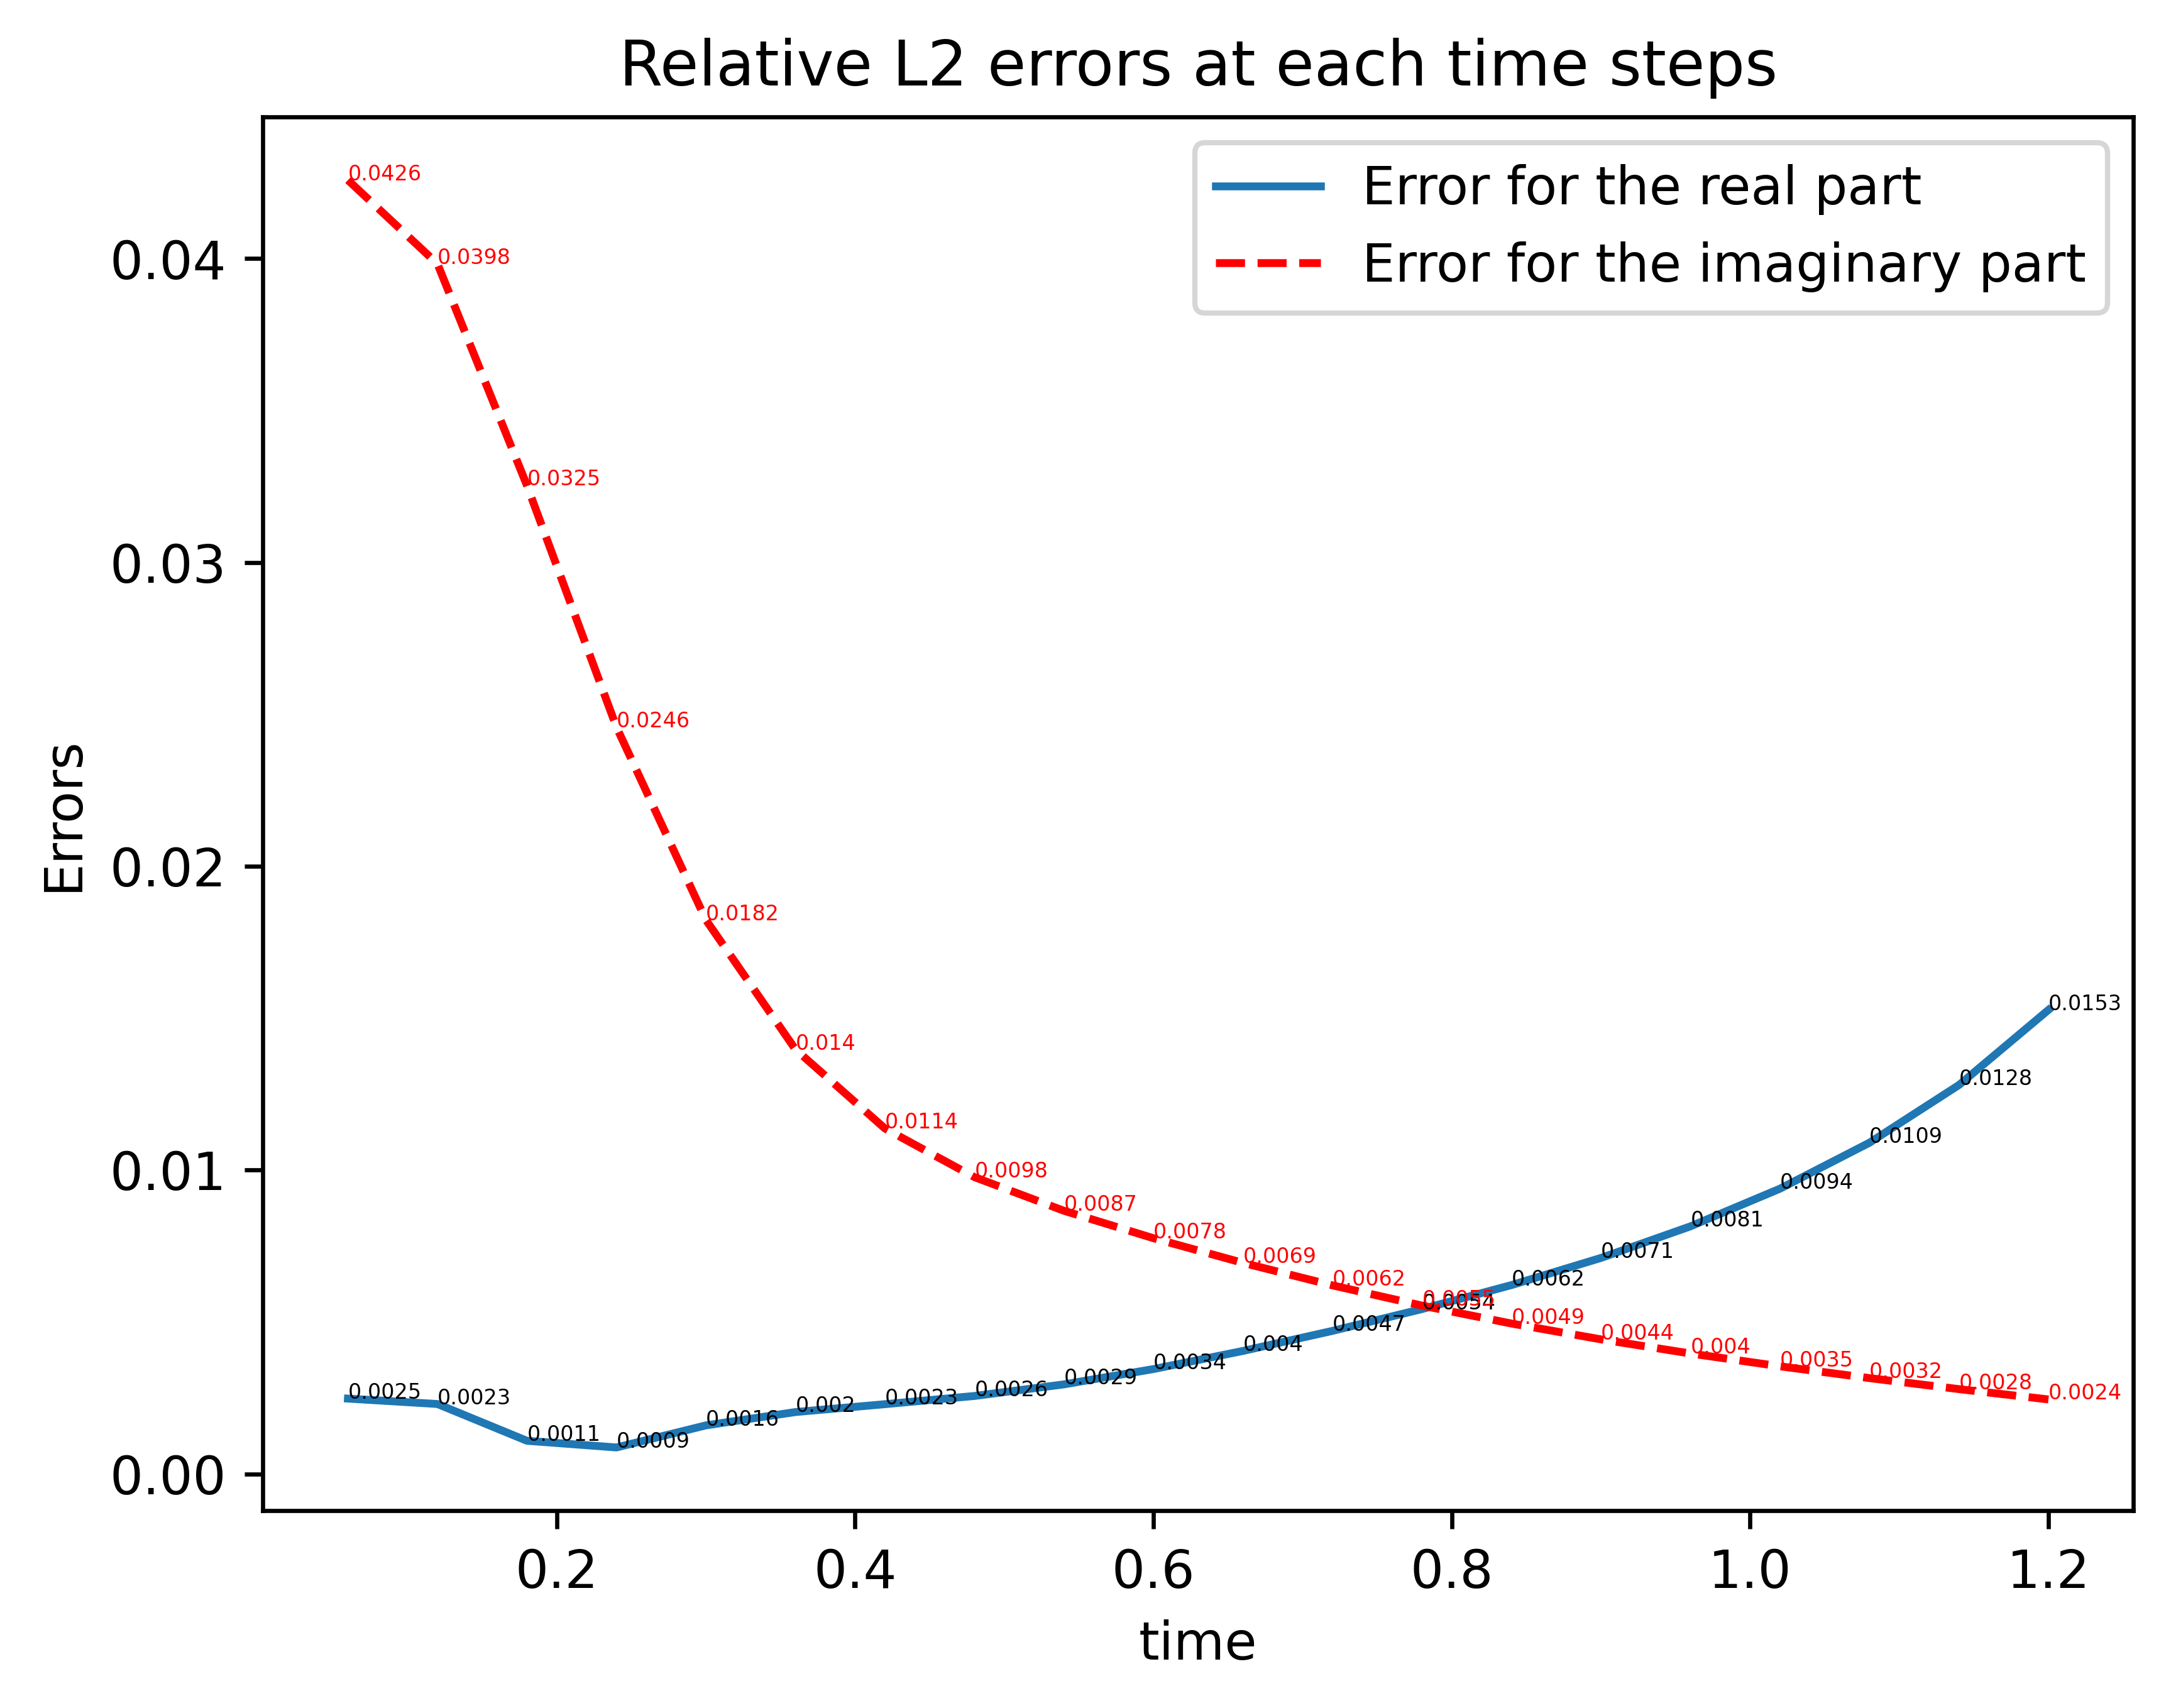

In [20]:
u1_pre_list, u2_pre_list, u1_exact_list, u2_exact_list = testNEKM(0.06, 20)

----- Global Error for u1 over whole time -----
Absolute L2 Norm Error: 0.003174
Absolute Max Norm Error: 0.009386
Relative L2 Norm Error: 0.5980%
Relative Max Norm Error: 0.9409%
----- Global Error for u2 over whole time -----
Absolute L2 Norm Error: 0.003284
Absolute Max Norm Error: 0.009785
Relative L2 Norm Error: 0.6643%
Relative Max Norm Error: 0.9929%
----- Global Error for (u1,u2) over whole time -----
Absolute L2 Norm Error: 0.003229
Absolute Max Norm Error: 0.009785
Relative L2 Norm Error: 0.6297%
Relative Max Norm Error: 0.9809%


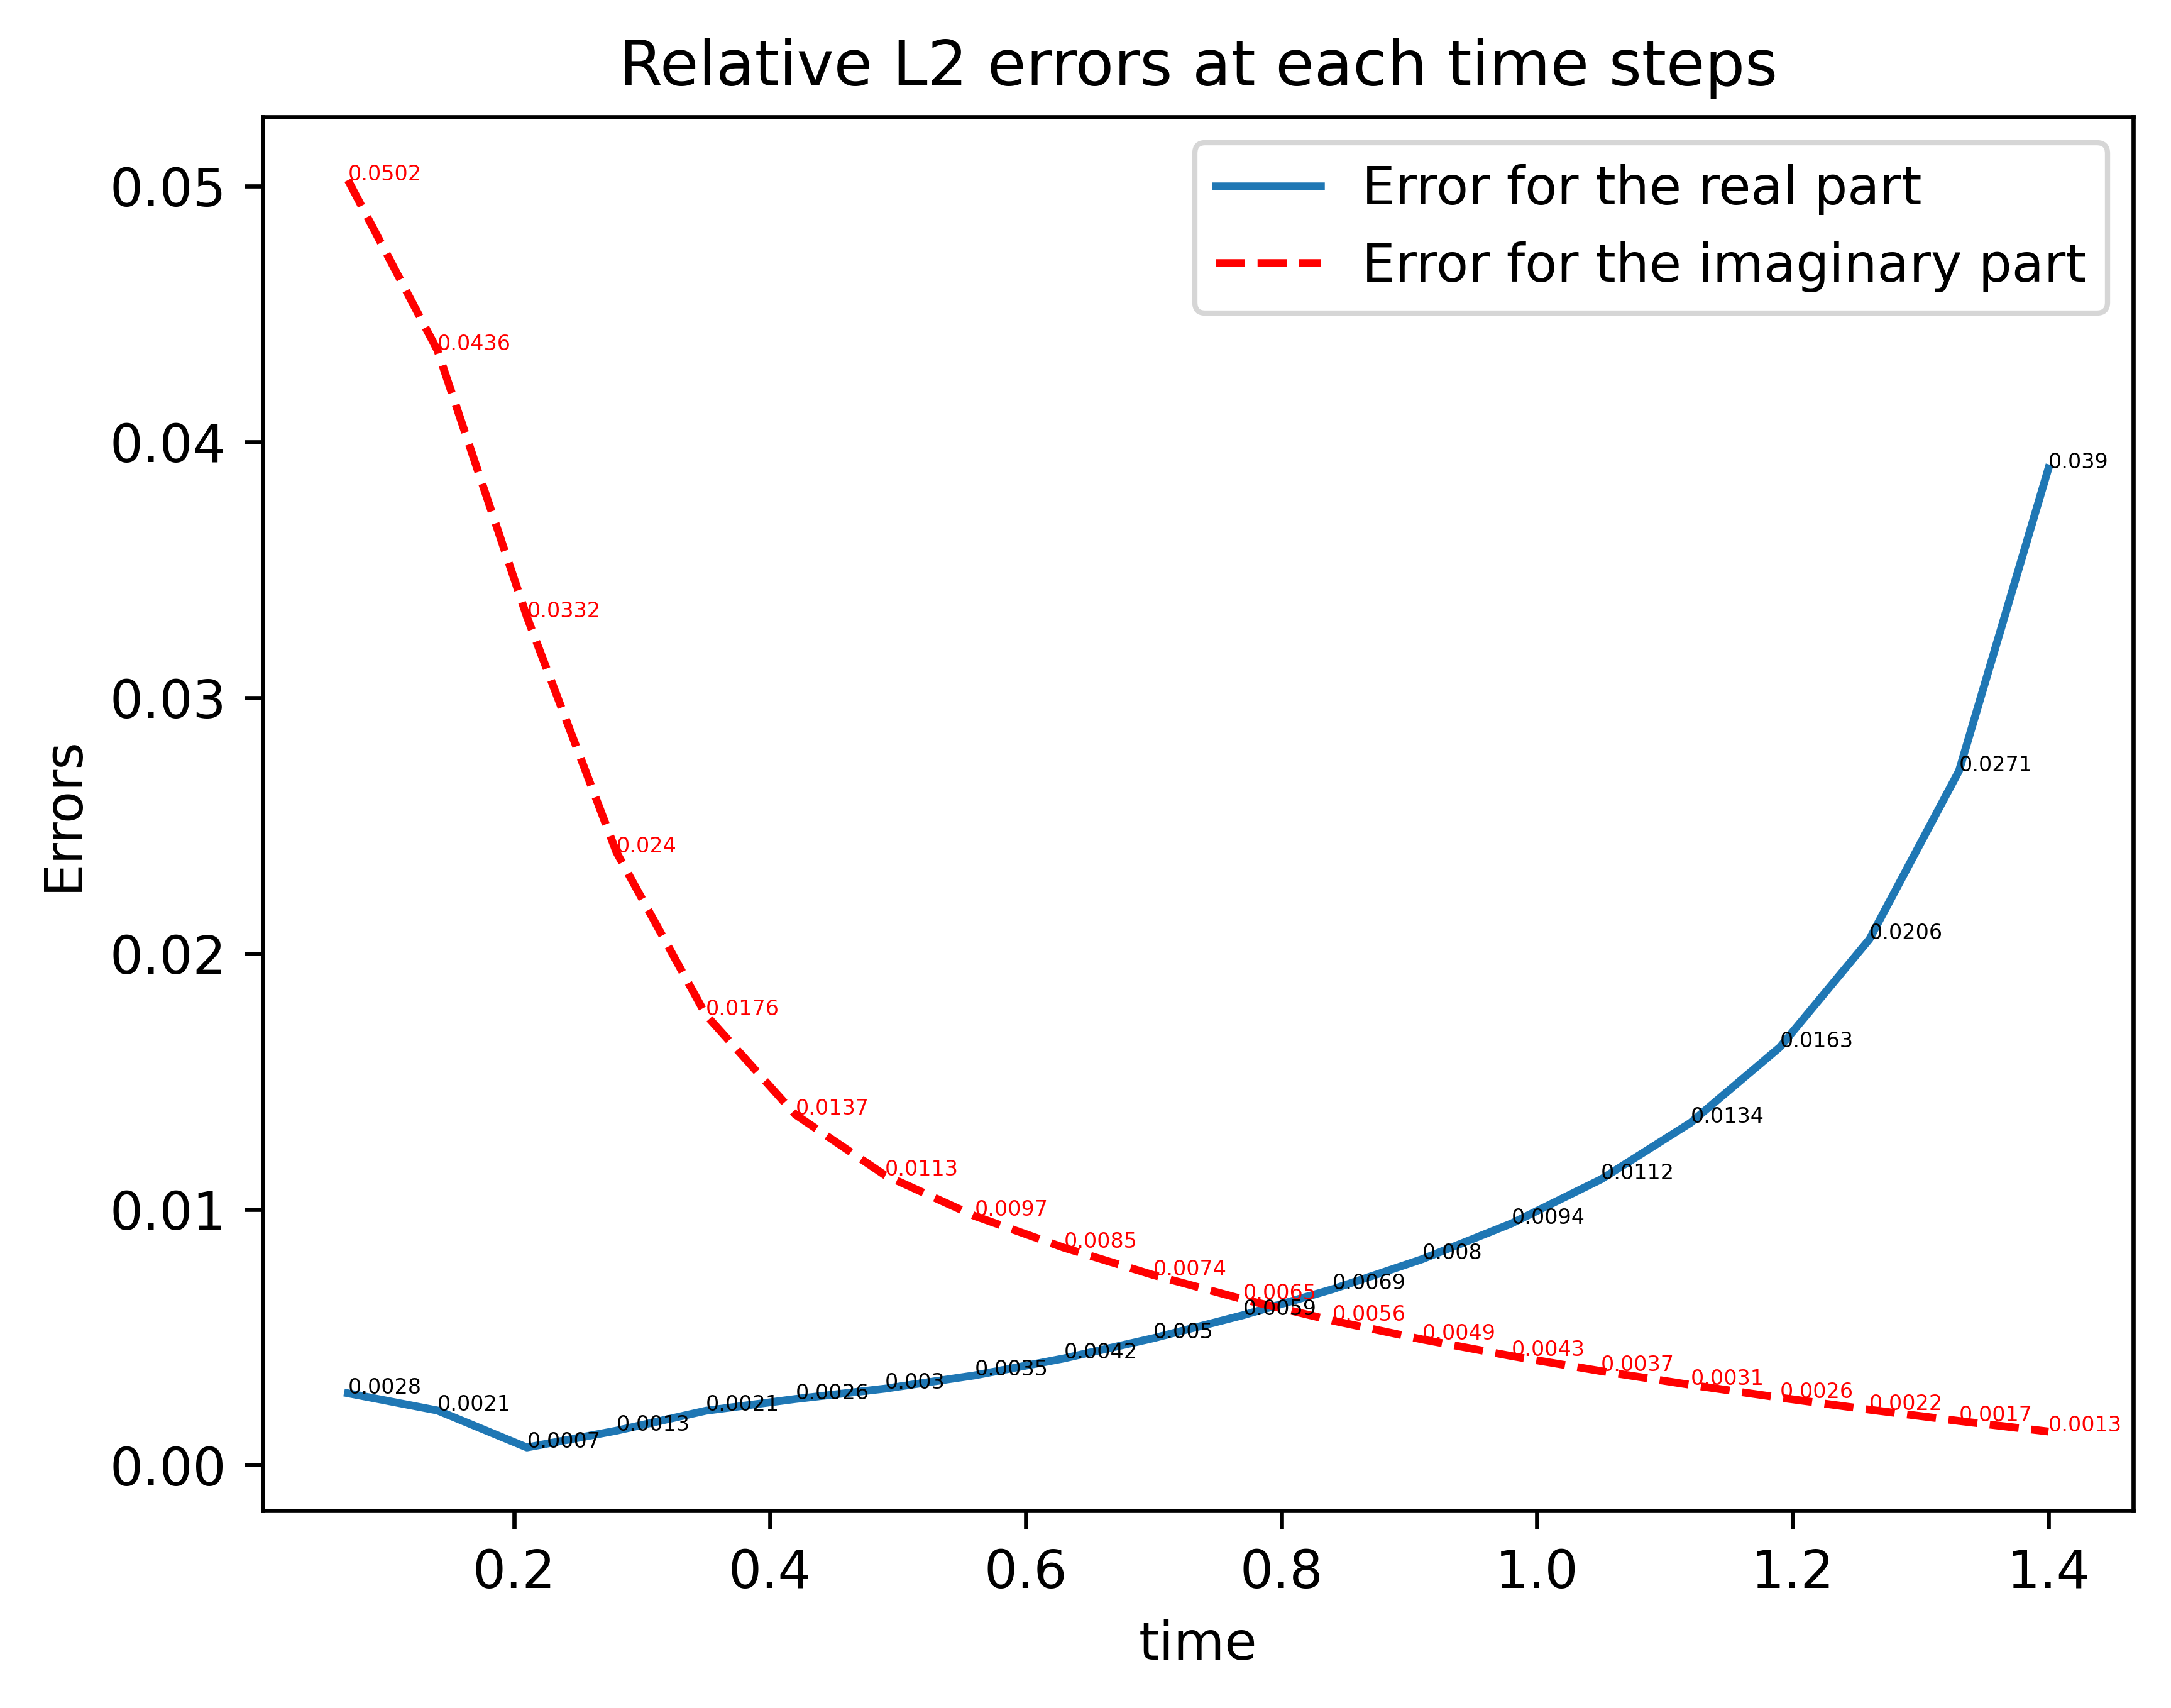

In [21]:
_, _, _, _ = testNEKM(0.07, 20)

----- Global Error for u1 over whole time -----
Absolute L2 Norm Error: 0.004171
Absolute Max Norm Error: 0.011760
Relative L2 Norm Error: 0.8426%
Relative Max Norm Error: 1.1798%
----- Global Error for u2 over whole time -----
Absolute L2 Norm Error: 0.004086
Absolute Max Norm Error: 0.012876
Relative L2 Norm Error: 0.7708%
Relative Max Norm Error: 1.2882%
----- Global Error for (u1,u2) over whole time -----
Absolute L2 Norm Error: 0.004129
Absolute Max Norm Error: 0.012876
Relative L2 Norm Error: 0.8051%
Relative Max Norm Error: 1.2882%


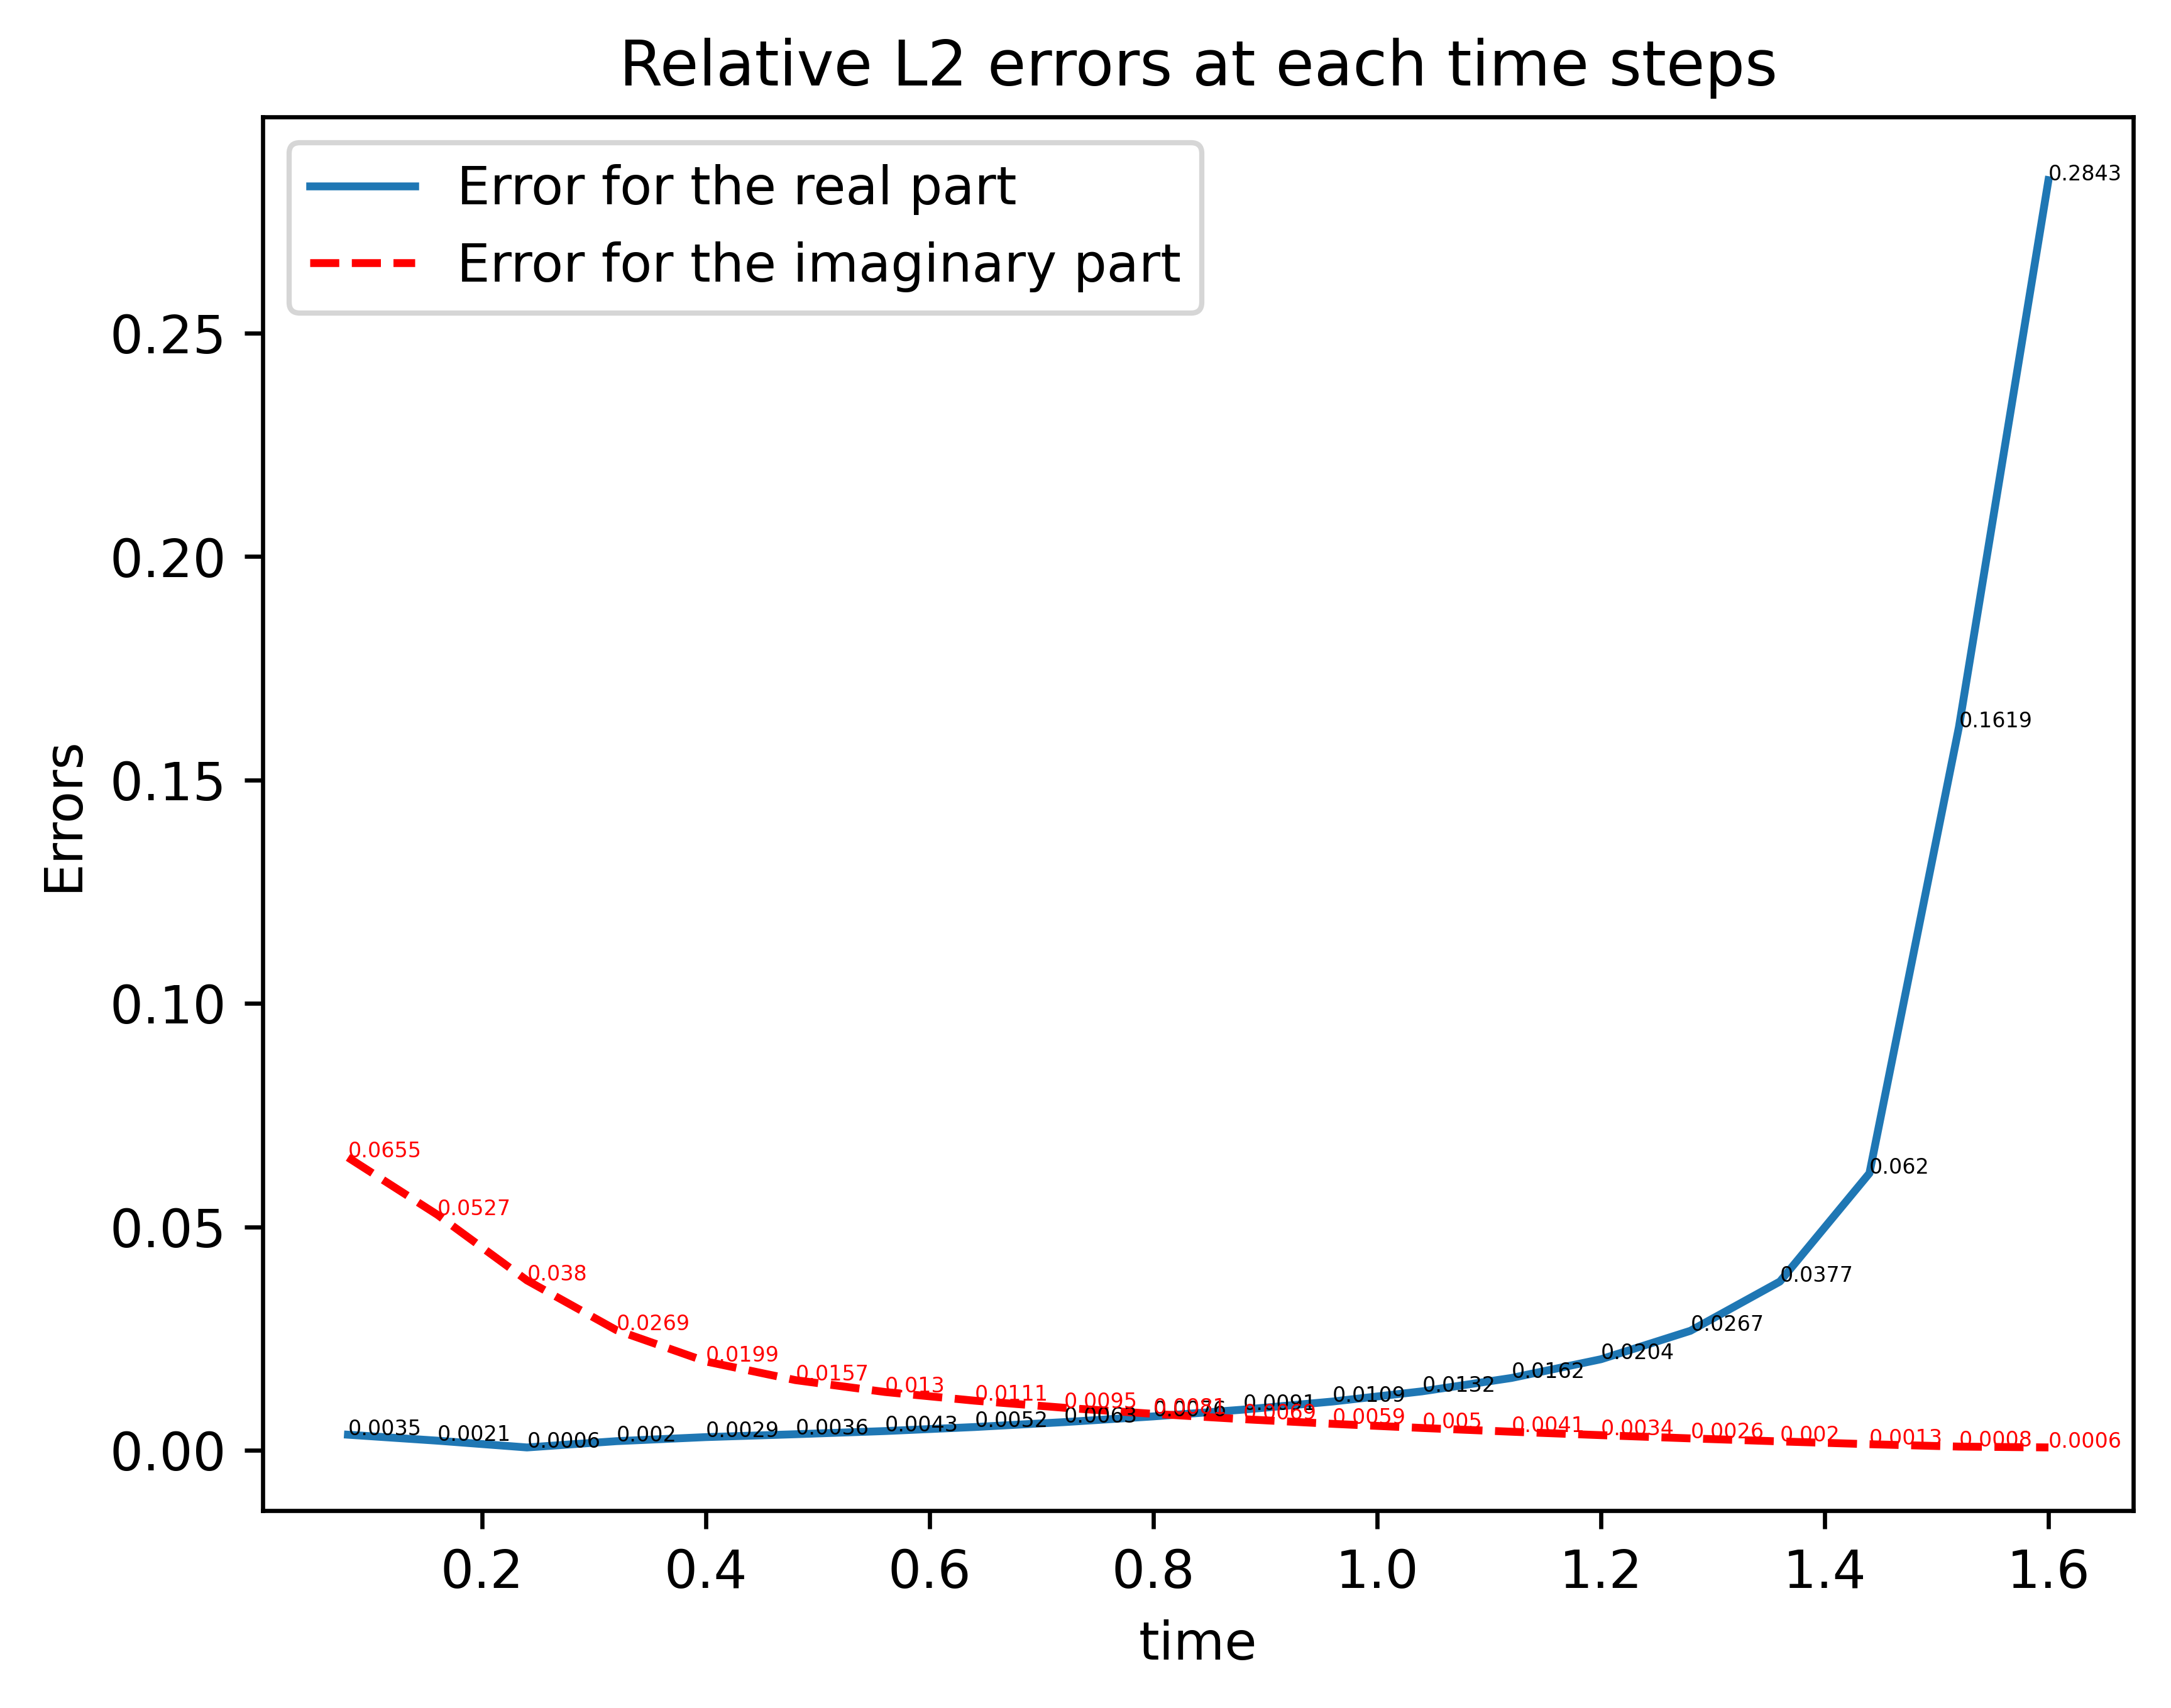

In [22]:
_, _, _, _ = testNEKM(0.08, 20)

In [23]:
def plotEvolution(u_list, tau, index_list): 
    num = len(index_list)
    u = np.zeros((num, N, N))
    
    all_data = [u_list[i].cpu().detach().numpy() for i in index_list]
    vmin = 0  
    vmax = 1  

    fig, axs = plt.subplots(1, num, figsize=(5 * num, 5), dpi=600, constrained_layout=True)
    if num == 1: 
        axs = [axs]  

    for i in range(num):
        u[i] = all_data[i].reshape((N, N))
        im = axs[i].imshow(u[i], cmap='inferno', extent=[0,1,0,1], origin='lower',vmin=vmin, vmax=vmax)  
        axs[i].set_title(f'Solution at time {round(tau*(index_list[i]+1),4)}')

    fig.colorbar(im, ax=axs[-1], shrink=1, pad=0.1)    

    plt.show()


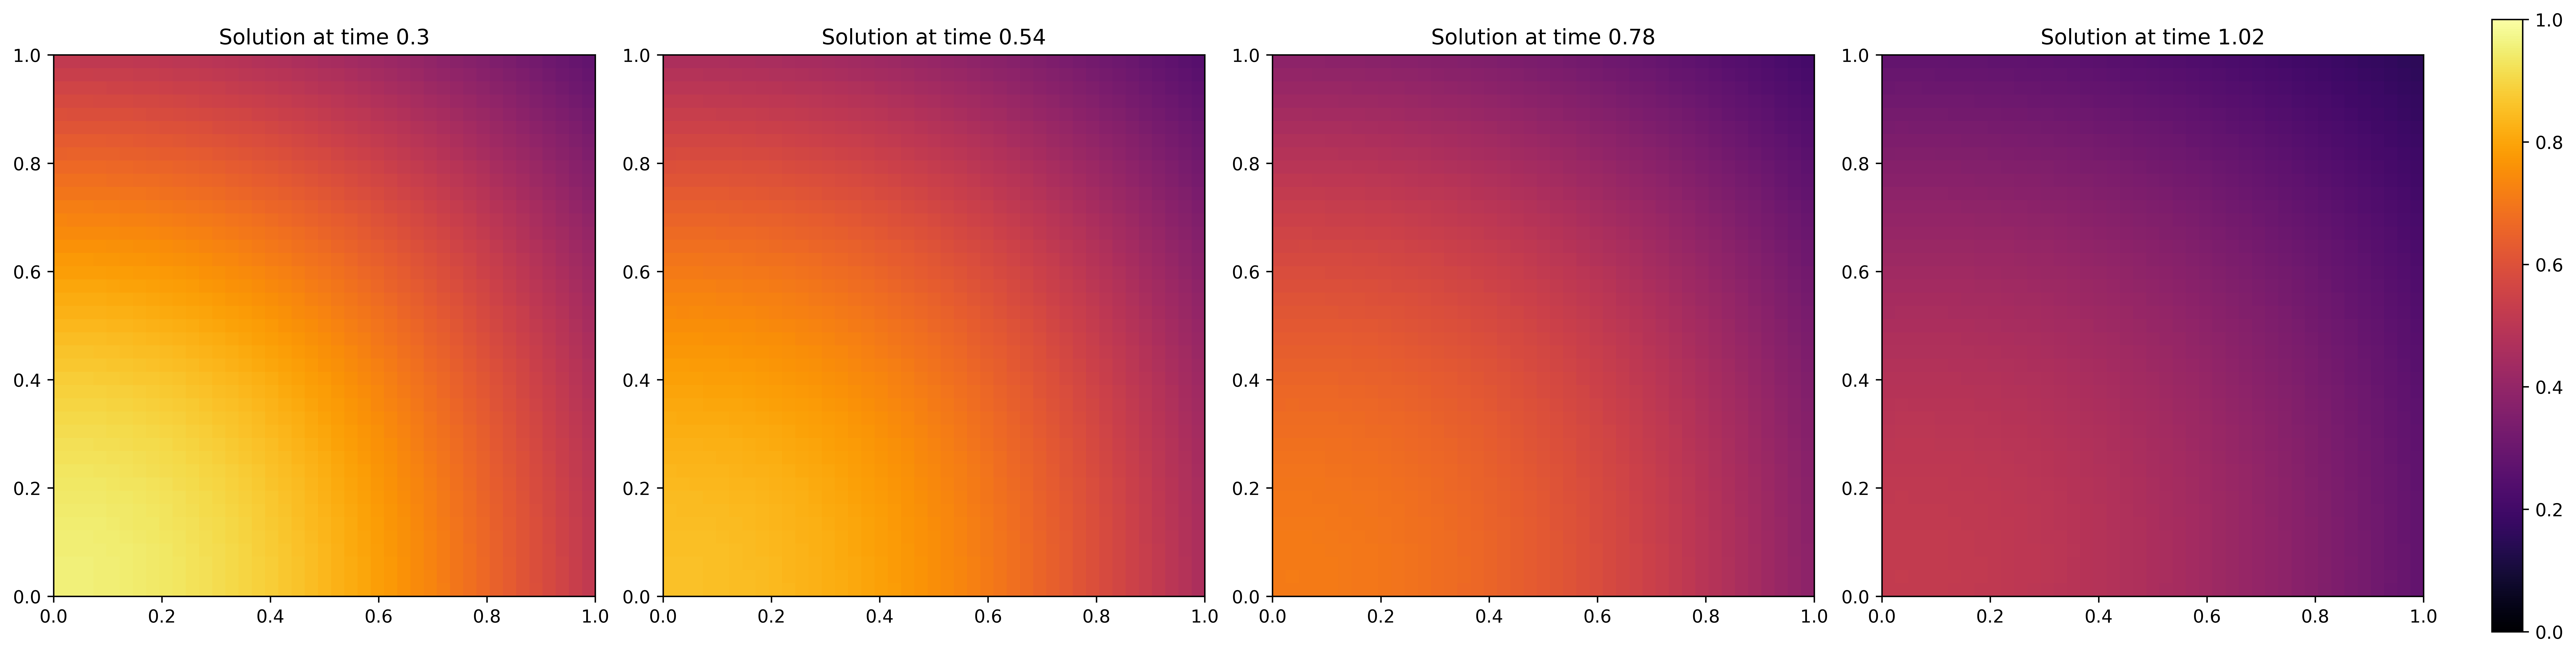

In [24]:
plotEvolution(u1_pre_list, 0.06, [4, 8, 12, 16])

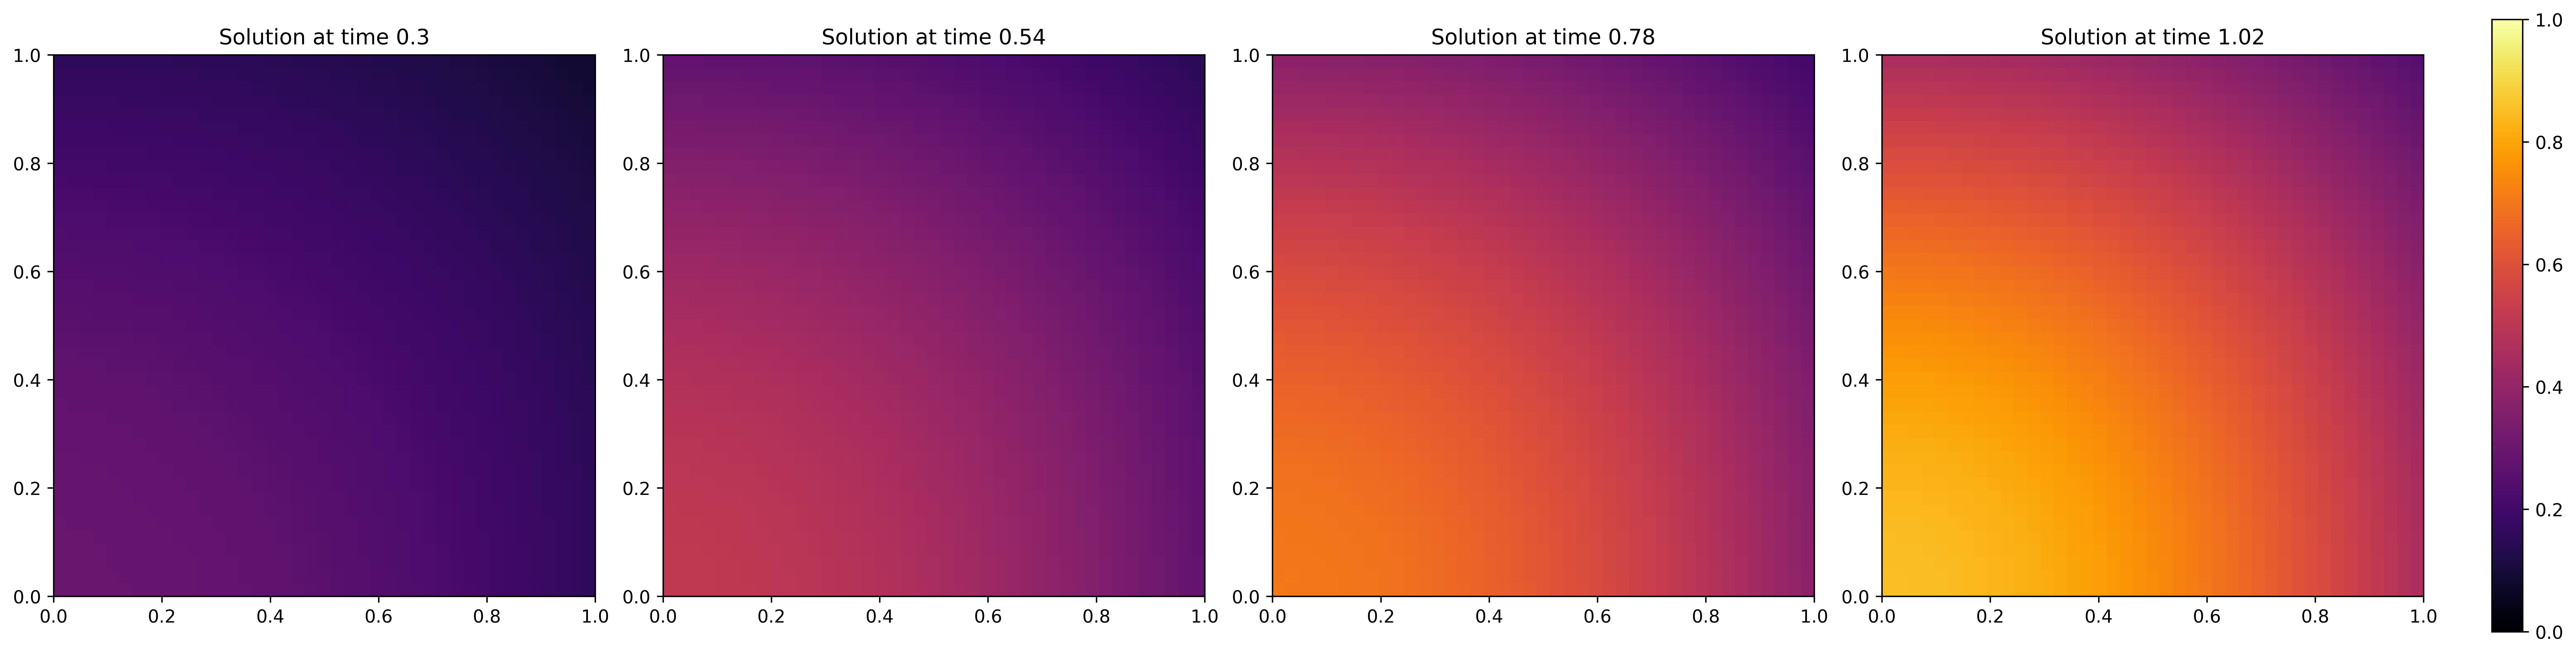

In [25]:
plotEvolution(u2_pre_list, 0.06, [4, 8, 12, 16])

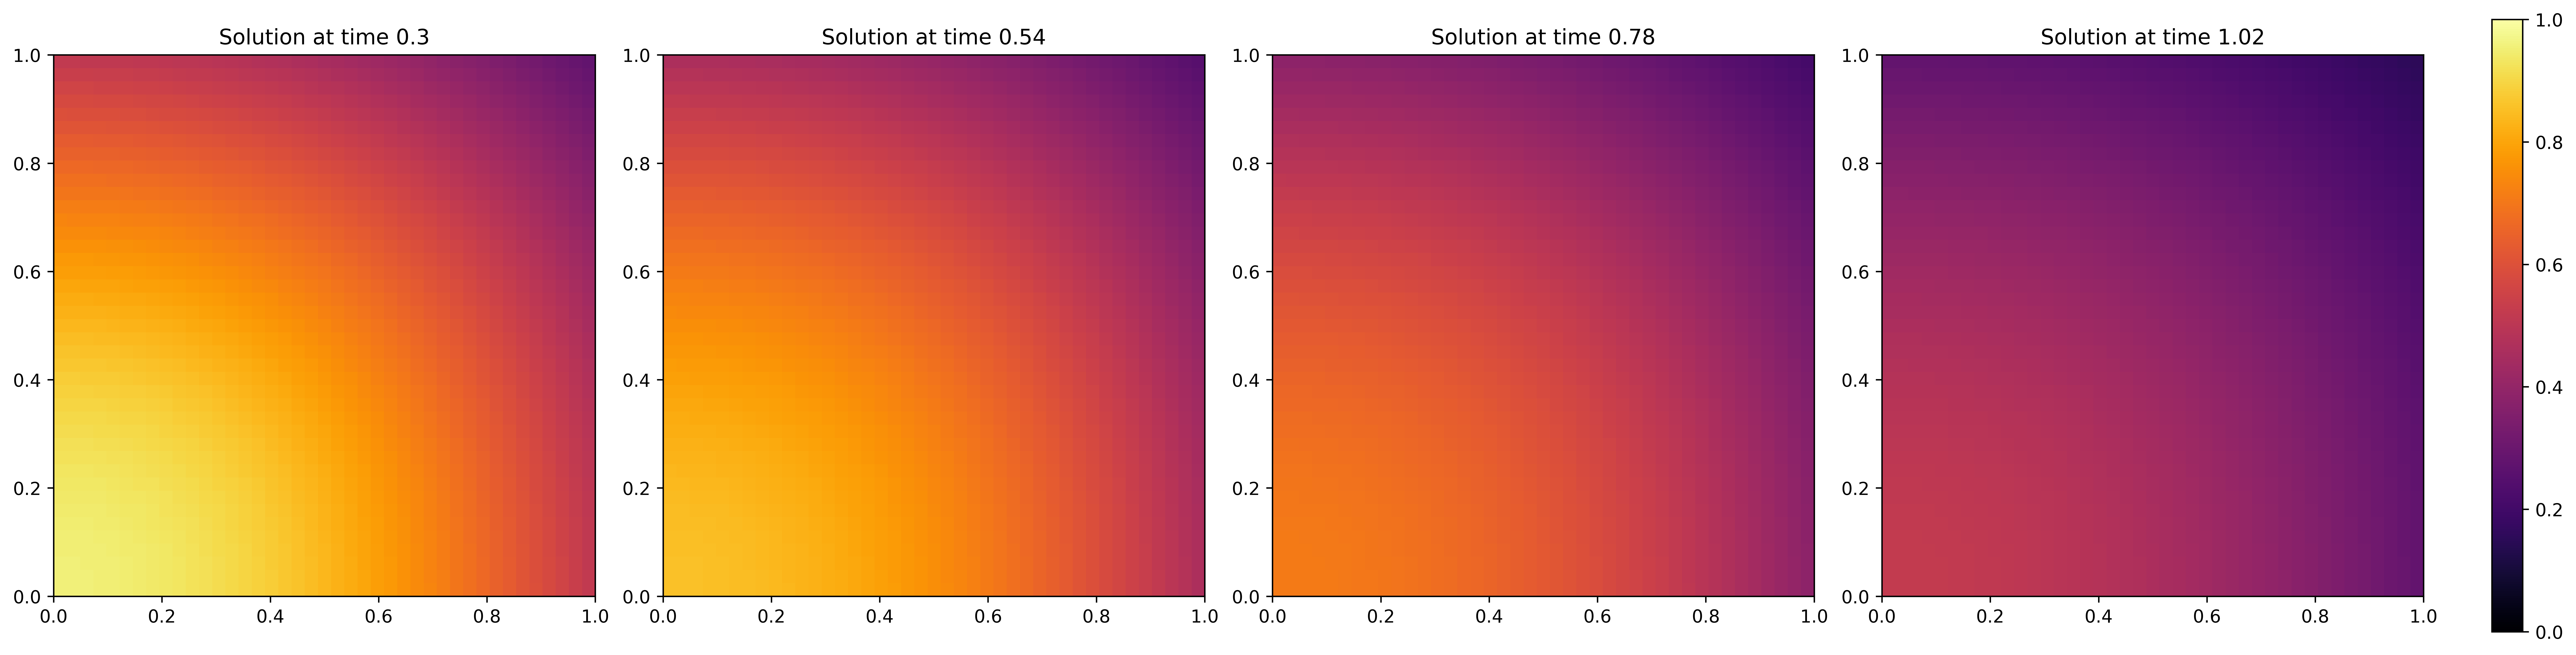

In [26]:
plotEvolution(u1_exact_list, 0.06, [4, 8, 12, 16])

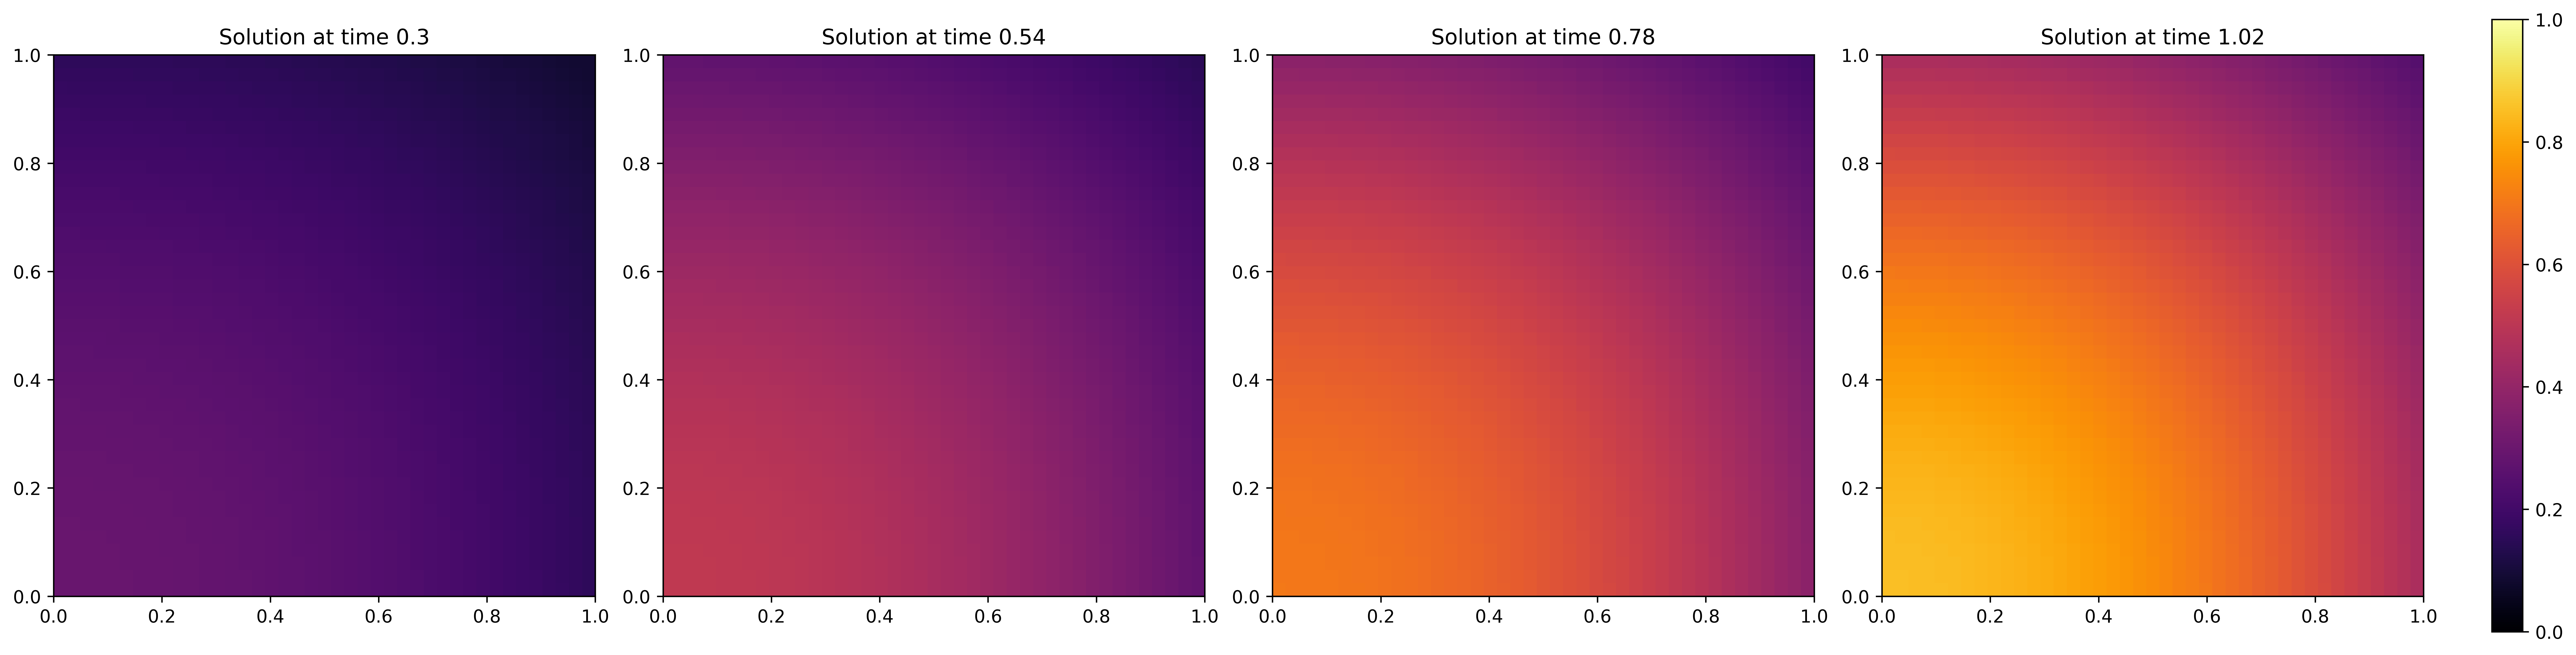

In [27]:
plotEvolution(u2_exact_list, 0.06, [4, 8, 12, 16])